In [15]:
import string
import math

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

import warnings
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings( # Suppress annoying harmless error.
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
%config IPCompleter.greedy=True
%matplotlib inline

In [227]:
def plot_error(y_actual, y_pred):
    error = (y_actual - y_pred)
    cm = plt.cm.get_cmap('GnBu')
    plt.scatter(y_actual, error, c=[abs(e) for e in error], s=3, cmap=cm)
    plt.ylabel('Error')
    plt.xlabel('Target value')
    plt.show()
    
    error.hist()

# 3.1.4 Challenge - KNN vs OLS
Find a data set and build a KNN Regression and an OLS regression. Compare the two. 
- How similar are they? 
- Do they miss in different ways?

Create a Jupyter notebook with your models. 
- At the end in a markdown cell write a few paragraphs to describe __the models' behaviors and why you favor one model or the other__. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. 
- Lastly, try to note __what it is about the data__ that causes the better model to outperform the weaker model.

# The Data: Gender Achievement Gaps in U.S. School Districts. Reardon, S.F., Fahle, E.M., Kalogrides, D., Podolsky, A., & Zárate, R.C. 

[See the NYT ARTICLE](https://www.nytimes.com/interactive/2018/06/13/upshot/boys-girls-math-reading-tests.html)

In [109]:
df = pd.read_csv('seda_gender_achievement_gaps_june2018.csv')
df = df.rename(lambda c: c.replace(' ', '_').replace('-', '').replace('(', '').replace(')', ''), axis='columns')
is_reliable = 'Reliable_District_Gap_Estimate;_District_has_>200_Male/Female_Students_per_Grade'
df = df[df[is_reliable] == 1]
df.reset_index(inplace=True) # df was indexed starting at 1, we want to start at 0

In [96]:
math_gap = 'EB_MaleFemale_Math_Achievement_Gap_SD_Units'
f = {
'pop': 'Average_Number_of_Students_in_a_GradeSubjectYear',
'income': 'SES_Composite__All_Adults',
'percent_white': 'Percent_of_White_Students_in_District',
'gender_income_gap': 'MaleFemale_Income_VGap',
}

In [97]:
features = np.array(list(f.values()))
features

array(['Average_Number_of_Students_in_a_GradeSubjectYear',
       'SES_Composite__All_Adults',
       'Percent_of_White_Students_in_District', 'MaleFemale_Income_VGap'],
      dtype='<U48')

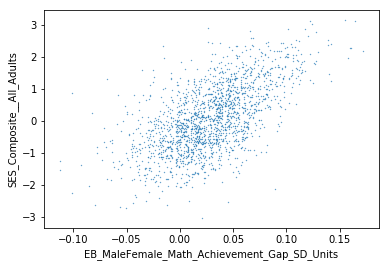

In [110]:
df.plot.scatter(math_gap, f['income'], s=0.1)

## For KNN purposes, normalize all features to between 0 and 1

In [114]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df.dropna(subset=features, inplace=True)
scaled = min_max_scaler.fit_transform(df[features])
df[features] = pd.DataFrame(scaled, columns=features)

,index,NCES_District_ID,LEA_Name,Fips_State_Code,State_Abbreviation,Average_Number_of_Students_in_a_GradeSubjectYear,Average_Number_of_Students_in_a_GenderGradeSubjectYear,EB_MaleFemale_Math_Achievement_Gap_SD_Units,EB_MaleFemale_ELA_Achievement_Gap_SD_Units,EB_Standard_Error_of_MaleFemale_Math_Achievement_Gap_SD_Units,...,MaleFemale_SES_Composite_Difference,Income_at_50th_percentile__All_Adults,Income_at_50th_percentile__Female_Adults,Income_at_50th_percentile__Male_Adults,MaleFemale_Income_VGap,Percent_of_Black_Students_in_District,Percent_of_Hispanic_Students_in_District,Percent_of_Other_Race_Students_in_District,Percent_of_White_Students_in_District,Reliable_District_Gap_Estimate;_District_has_>200_Male/Female_Students_per_Grade
0,1,100006,Marshall County,1,AL,0.000,215,-0.014,-0.277,0.018,...,1.157,46291.000,18801.000,29471.000,0.472,0.010,0.153,0.005,0.838,1
1,2,100007,Hoover City,1,AL,0.009,514,0.092,-0.199,0.017,...,1.752,91103.000,30829.000,49896.000,0.476,0.238,0.058,0.068,0.640,1
2,3,100008,Madison City,1,AL,0.004,346,0.068,-0.245,0.019,...,3.459,103228.000,30709.000,70076.000,0.656,0.203,0.034,0.093,0.675,1
3,14,100210,Auburn City,1,AL,0.002,280,0.042,-0.218,0.019,...,1.450,72109.000,9990.000,15481.000,0.313,0.258,0.026,0.087,0.634,1
4,15,100240,Autauga County,1,AL,0.005,381,0.047,-0.220,0.017,...,1.175,65988.000,23613.000,39825.000,0.503,0.238,0.022,0.017,0.727,1
5,16,100270,Baldwin County,1,AL,0.026,1107,0.034,-0.228,0.015,...,1.347,54735.000,20817.000,34372.000,0.468,0.138,0.052,0.015,0.802,1
6,20,100390,Birmingham City,1,AL,0.021,952,-0.113,-0.333,0.016,...,0.499,29858.000,20936.000,25463.000,0.190,0.954,0.033,0.002,0.011,1
7,21,100420,Blount County,1,AL,0.004,327,0.035,-0.220,0.016,...,1.172,51966.000,22165.000,34737.000,0.446,0.011,0.116,0.004,0.875,1
8,25,100540,Calhoun County,1,AL,0.005,367,0.070,-0.189,0.017,...,1.358,47000.000,18660.000,34325.000,0.543,0.137,0.027,0.008,0.835,1
9,28,100660,Chilton County,1,AL,0.003,303,0.017,-0.244,0.017,...,1.225,42651.000,20753.000,33959.000,0.493,0.121,0.101,0.005,0.779,1


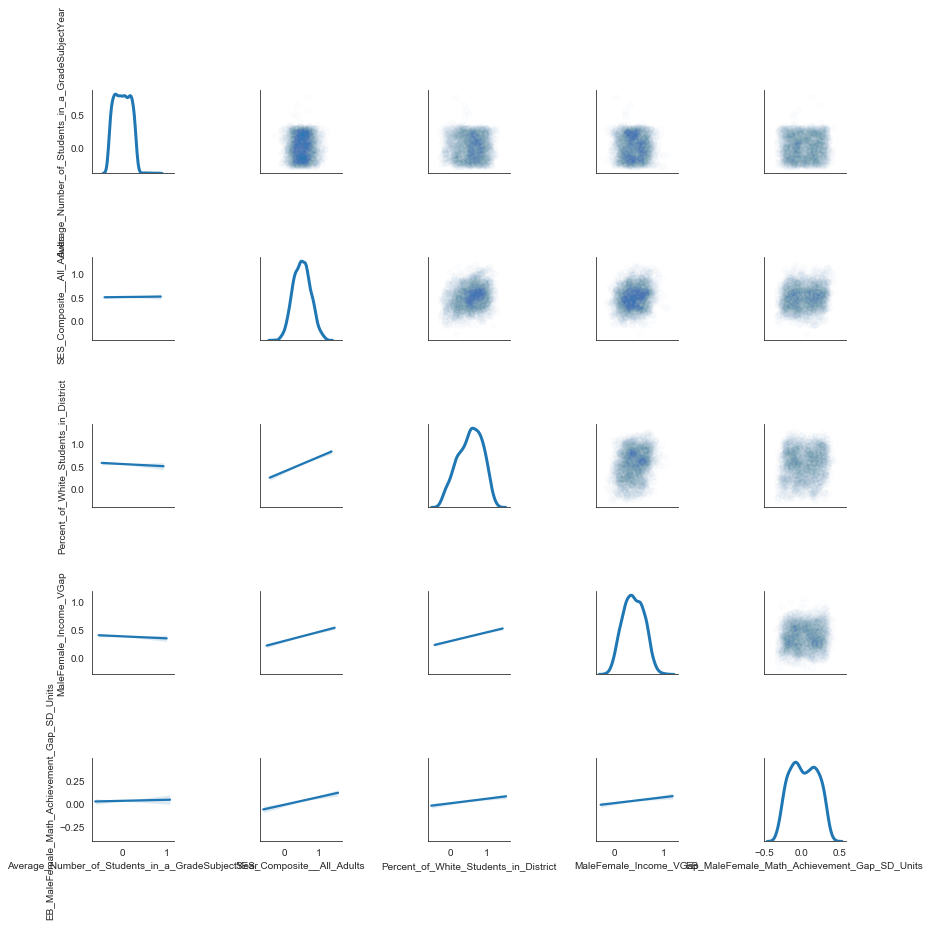

In [236]:
# Make the scatterplot matrix
# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, np.append(features, math_gap)].dropna()
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.01)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [1]:
sns.heatmap(df[features].corr())
plt.show()

NameError: name 'sns' is not defined

# OLS Model

In [220]:
def create_lm(linear_formula, df):
    lm = smf.ols(formula=linear_formula, data=df).fit()
    print(f'\nParams:\n {lm.params}')
    print(f'\nPvalues:\n {lm.pvalues}')
    print(f'\nR^2:\n {lm.rsquared}')
    return lm

lm_features = '+'.join(features) # {income}+{percent_white}+{gender_income_gap}
linear_formula = f'{math_gap} ~ {lm_features}'
lm = create_lm(linear_formula, df)


Params:
 Intercept                                          -0.060
Average_Number_of_Students_in_a_GradeSubjectYear   -0.057
SES_Composite__All_Adults                           0.107
Percent_of_White_Students_in_District               0.016
MaleFemale_Income_VGap                              0.067
dtype: float64

Pvalues:
 Intercept                                          0.000
Average_Number_of_Students_in_a_GradeSubjectYear   0.002
SES_Composite__All_Adults                          0.000
Percent_of_White_Students_in_District              0.000
MaleFemale_Income_VGap                             0.000
dtype: float64

R^2:
 0.4449037558716703


# KNN

In [117]:
df[features].describe()

,Average_Number_of_Students_in_a_GradeSubjectYear,SES_Composite__All_Adults,Percent_of_White_Students_in_District,MaleFemale_Income_VGap
count,1793.000,1793.000,1793.000,1793.000
mean,0.014,0.504,0.547,0.388
std,0.039,0.168,0.284,0.122
min,0.000,0.000,0.000,0.000
25%,0.002,0.384,0.316,0.301
50%,0.005,0.492,0.590,0.379
75%,0.013,0.622,0.798,0.468
max,1.000,1.000,1.000,1.000


In [127]:
def test_KNNs(k, scores, std, scores_w, std_w, X, Y, print_info=False):
    # un=weighted.
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X, Y)
    # weighted.
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X, Y)

    # EVAL
    score = cross_val_score(knn, X, Y, cv=5)
    score_w = cross_val_score(knn_w, X, Y, cv=5)
    if print_info:
        print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
        print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
    scores += [abs(score.mean())]
    std += [abs(score.std())]
    scores_w += [abs(score_w.mean())]
    std_w += [abs(score_w.std())]
    return knn, knn_w

## Identify optimal K value

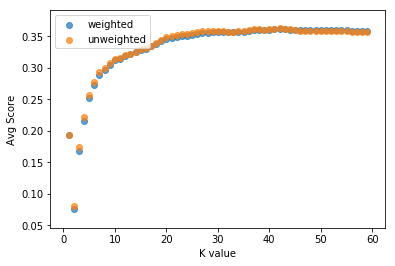

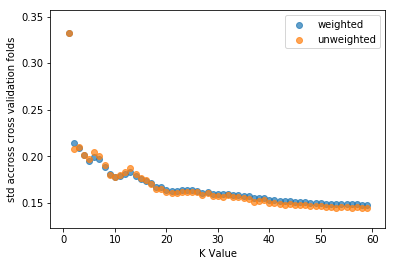

In [125]:
scores = []
scores_w = []
std = []
std_w = []
X = df[features]
Y = df[math_gap]
k_range = range(1, 60)
for k in k_range:
    test_KNNs(k, scores, std, scores_w, std_w, X, Y)

w = plt.scatter(k_range, scores_w, label='weighted', alpha=0.7)
plt.ylabel('score')
plt.xlabel('K value')
u = plt.scatter(k_range, scores, label='unweighted', alpha=0.7)
plt.ylabel('Avg Score')
plt.legend()
plt.show()

# std
w = plt.scatter(k_range, std_w, label='weighted', alpha=0.7)
plt.ylabel('std accross cross validation folds')
plt.xlabel('K Value')
u = plt.scatter(k_range, std, label='unweighted', alpha=0.7)
plt.legend()
plt.show()

# Asses Points of Failure for KNN and OLS

In [180]:
scores = []
scores_w = []
std = []
std_w = []

# Test and holdout data
mid = int(len(df) / 2)
X = df.iloc[0:mid-1, :][features]
X_holdout = df.iloc[mid:len(df)-1,:][features]

Y = df.iloc[0:mid-1, :][math_gap]
Y_holdout = df.iloc[mid:len(df)-1, :][math_gap]

## KNN and OLS both display *Heteroscedasticity*, increasing in error on the lower and upper extremes
Though the error is normaly distributed.

[0.42497611 0.42052371 0.40099774 0.48819433 0.30407542]


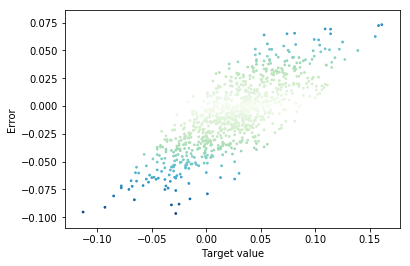

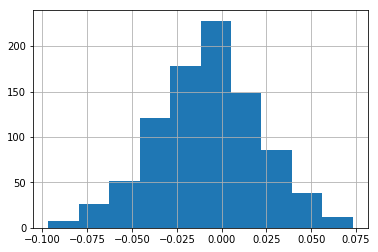

In [226]:
knn, knn_w = test_KNNs(k, scores, std, scores_w, std_w, X, Y)
cv = cross_val_score(knn_w, X, Y, cv=5)
print(cv)
y_pred = knn_w.predict(X_holdout)
plot_error(Y_holdout, y_pred)

### OLS Model

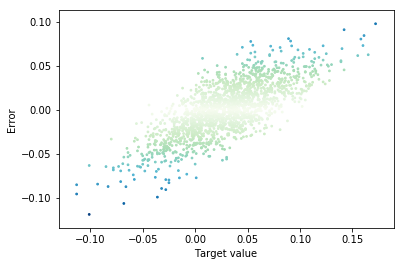

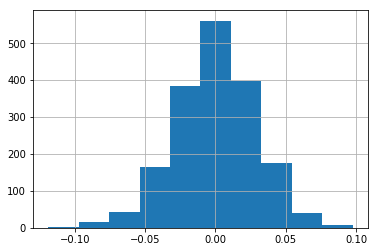

In [229]:
lm_y_pred = lm.predict(df[features])
plot_error(df[math_gap], lm_y_pred)

# Conclusions

## Questions:
- how do I occomodate the edges of the model better? Do I transform the Target Value?
- __Why does the OLS perform better__? Perhaps simply because there's more of a linear relationship to the Target? Or is the difference *that* significant between the models?